<a href="https://colab.research.google.com/github/talhaanwarch/ODIR2019/blob/master/sub0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

#connect drive with colab notebook/

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


https://github.com/keras-team/keras/issues/8130
https://stackoverflow.com/questions/56796331/how-to-input-multiple-images-with-flow-from-dataframe-in-keras

In [2]:
#following are libraries to unpack 7z file
!pip install patool 
!pip install pyunpack
from pyunpack import Archive

In [0]:
import pandas as pd
import numpy as np
import cv2

In [4]:

#create a folder name as data
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
#path where our data is saved
path='/content/drive/My Drive/ghina/thesis/'

In [0]:
#extract the 7z file in data folder we created above
#this not only extract the data but move it from drive to colab for efficinet processing
#it will take some time
Archive(path+'ODIR-5K_Training_Images.7z').extractall('data')

In [0]:
Archive(path+'ODIR-5K_Testing_Images.7z').extractall('data')


In [0]:
#read the annottion file
annotation=pd.read_excel(path+'ODIR-5K_Training_Annotations(Updated)_V2.xlsx')

In [0]:

#normal (N), diabetes (D), glaucoma (G), cataract (C), AMD (A), hypertension (H), myopia (M) and other diseases/abnormalities (O)

In [10]:
#print first 5 rows of annotation file
annotation=annotation.sample(frac=1)
annotation.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
989,994,65,Female,994_left.jpg,994_right.jpg,normal fundus,chorioretinal atrophy,0,0,0,0,0,0,0,1
745,747,49,Male,747_left.jpg,747_right.jpg,maculopathy,maculopathy,0,0,0,0,0,0,0,1
1621,2161,59,Male,2161_left.jpg,2161_right.jpg,moderate non proliferative retinopathy,cataract,0,1,0,1,0,0,0,0
1315,1476,68,Male,1476_left.jpg,1476_right.jpg,normal fundus,glaucoma,0,0,1,0,0,0,0,0
3099,4240,50,Female,4240_left.jpg,4240_right.jpg,normal fundus,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0


In [11]:
test=pd.read_csv(path+'XYZ_ODIR.csv')
print(len(test))
test.head()


500


,ID,N,D,G,C,A,H,M,O
0,937,0,0,0,0,0,0,0,0
1,967,0,0,0,0,0,0,0,0
2,988,0,0,0,0,0,0,0,0
3,995,0,0,0,0,0,0,0,0
4,1000,0,0,0,0,0,0,0,0


In [12]:
left_test=[]
right_test=[]
ID=[]
for i in test['ID']:
  ID.append(i)
  left_test.append(str(i)+'_left.jpg')
  right_test.append(str(i)+'_right.jpg')

name_df=pd.DataFrame(zip(ID,left_test,right_test),columns=['ID','Left-Fundus','Right-Fundus'])
name_df.head()
result = pd.merge(name_df, test, on='ID')
result.head()

,ID,Left-Fundus,Right-Fundus,N,D,G,C,A,H,M,O
0,937,937_left.jpg,937_right.jpg,0,0,0,0,0,0,0,0
1,967,967_left.jpg,967_right.jpg,0,0,0,0,0,0,0,0
2,988,988_left.jpg,988_right.jpg,0,0,0,0,0,0,0,0
3,995,995_left.jpg,995_right.jpg,0,0,0,0,0,0,0,0
4,1000,1000_left.jpg,1000_right.jpg,0,0,0,0,0,0,0,0


In [0]:
for i in ['G',	'C',	'A',	'H',	'M']:
  duplicate=annotation[annotation[i]==1]
  annotation=annotation.append([duplicate]*5,ignore_index=True)

In [15]:
len(annotation)

8790

In [0]:
img_shape=256*1

In [0]:
#https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [0]:
def load_ben_color(image, sigmaX=10):
    #image = cv2.imread(path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (img_shape, img_shape))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    
    
    return image

In [0]:
from keras_preprocessing.image import ImageDataGenerator

train_data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    preprocessing_function=load_ben_color
)

val_data_gen= ImageDataGenerator(
    rescale=1/255
    
)

In [0]:
def get_flow_from_dataframe(generator, dataframe,directory_path,
                            image_shape=(img_shape, img_shape),
                            #subset='training',
                             batch_size=35):
    train_generator_1 = generator.flow_from_dataframe(dataframe,
                                                      directory=directory_path,
                                                      target_size=(img_shape,img_shape),
                                                      x_col="Left-Fundus",
                                                      y_col=['N'	,'D'	,'G',	'C',	'A'	,'H'	,'M',	'O'],
                                                      class_mode='other',
                                                      shuffle=False,
                                                      batch_size=batch_size,
                                                      seed=7,
                                                      #subset=subset
                                                      )

    train_generator_2 = generator.flow_from_dataframe(dataframe, 
                                                      directory=directory_path,
                                                      target_size=(img_shape,img_shape),
                                                      x_col="Right-Fundus",
                                                      y_col=['N'	,'D'	,'G',	'C',	'A'	,'H'	,'M',	'O'],
                                                      class_mode='other',
                                                      shuffle=False,
                                                      batch_size=batch_size,
                                                      seed=7,
                                                      #subset=subset
                                                      )
    while True:
        x_1 = train_generator_1.next()
        x_2 = train_generator_2.next()

        yield [x_1[0], x_2[0]], x_1[1]

In [0]:
batch_size=35
train_gen = get_flow_from_dataframe(train_data_gen, annotation, image_shape=(img_shape, img_shape),
                                        directory_path="data/ODIR-5K_Training_Dataset/",batch_size=batch_size)
# valid_gen = get_flow_from_dataframe(val_data_gen, val_annotation, image_shape=(img_shape, img_shape),
#                                         directory_path="data/ODIR-5K_Training_Dataset/",batch_size=batch_size)
test_gen = get_flow_from_dataframe(val_data_gen, result, image_shape=(img_shape, img_shape),
                                        directory_path="data/ODIR-5K_Testing_Images/",batch_size=batch_size)

In [22]:
img_shape

256

In [23]:
from keras.models import Sequential,Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from keras.layers import GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

import keras
left_input=Input(shape=(img_shape,img_shape,3))
right_input=Input(shape=(img_shape,img_shape,3))

left_model = VGG16(input_shape =  (img_shape,img_shape,3), include_top = False, weights = 'imagenet')
right_model = VGG16(input_shape =  (img_shape,img_shape,3), include_top = False, weights = 'imagenet')

left_model.trainable = False
right_model.trainable = False

In [25]:
pt_depth = left_model.get_output_shape_at(0)[-1]
pt_depth

512

In [0]:
left_model_features = left_model(left_input)
right_model_features = right_model(right_input)
# left_model_features=left_model.output
# right_model_features=right_model.output

In [0]:
left_bn_features = BatchNormalization()(left_model_features)
right_bn_features = BatchNormalization()(right_model_features)


In [0]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
def attention(bn):
  attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn)
  attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
  attn_layer = LocallyConnected2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
  up_c2_w = np.ones((1, 1, 1, pt_depth))
  up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', activation = 'linear', use_bias = False, weights = [up_c2_w])
  up_c2.trainable = False
  attn_layer = up_c2(attn_layer)
  mask_features = multiply([attn_layer, bn])
  gap_features = GlobalAveragePooling2D()(mask_features)
  gap_mask = GlobalAveragePooling2D()(attn_layer)
  # to account for missing values from the attention model
  gap = Lambda(lambda x: x[0]/x[1])([gap_features, gap_mask])

  return gap

In [0]:
left_atten=attention(left_bn_features)
right_atten=attention(right_bn_features)

In [0]:
con = concatenate([left_atten, right_atten])
gap_dr = Dropout(0.5)(con)
fc1=Dense(128, activation = 'relu')(gap_dr)
fc2=Dense(64, activation = 'relu')(fc1)
out = Dense(8, activation = 'sigmoid')(fc2)

In [0]:

for layer in right_model.layers:
        layer.name = layer.name + '_right'
for layer in left_model.layers:
  layer.name = layer.name + '_left'

left_model.name="left_vgg16"
right_model.name="right_vgg16"

In [0]:
model =Model(inputs=[left_input, right_input], outputs=out)


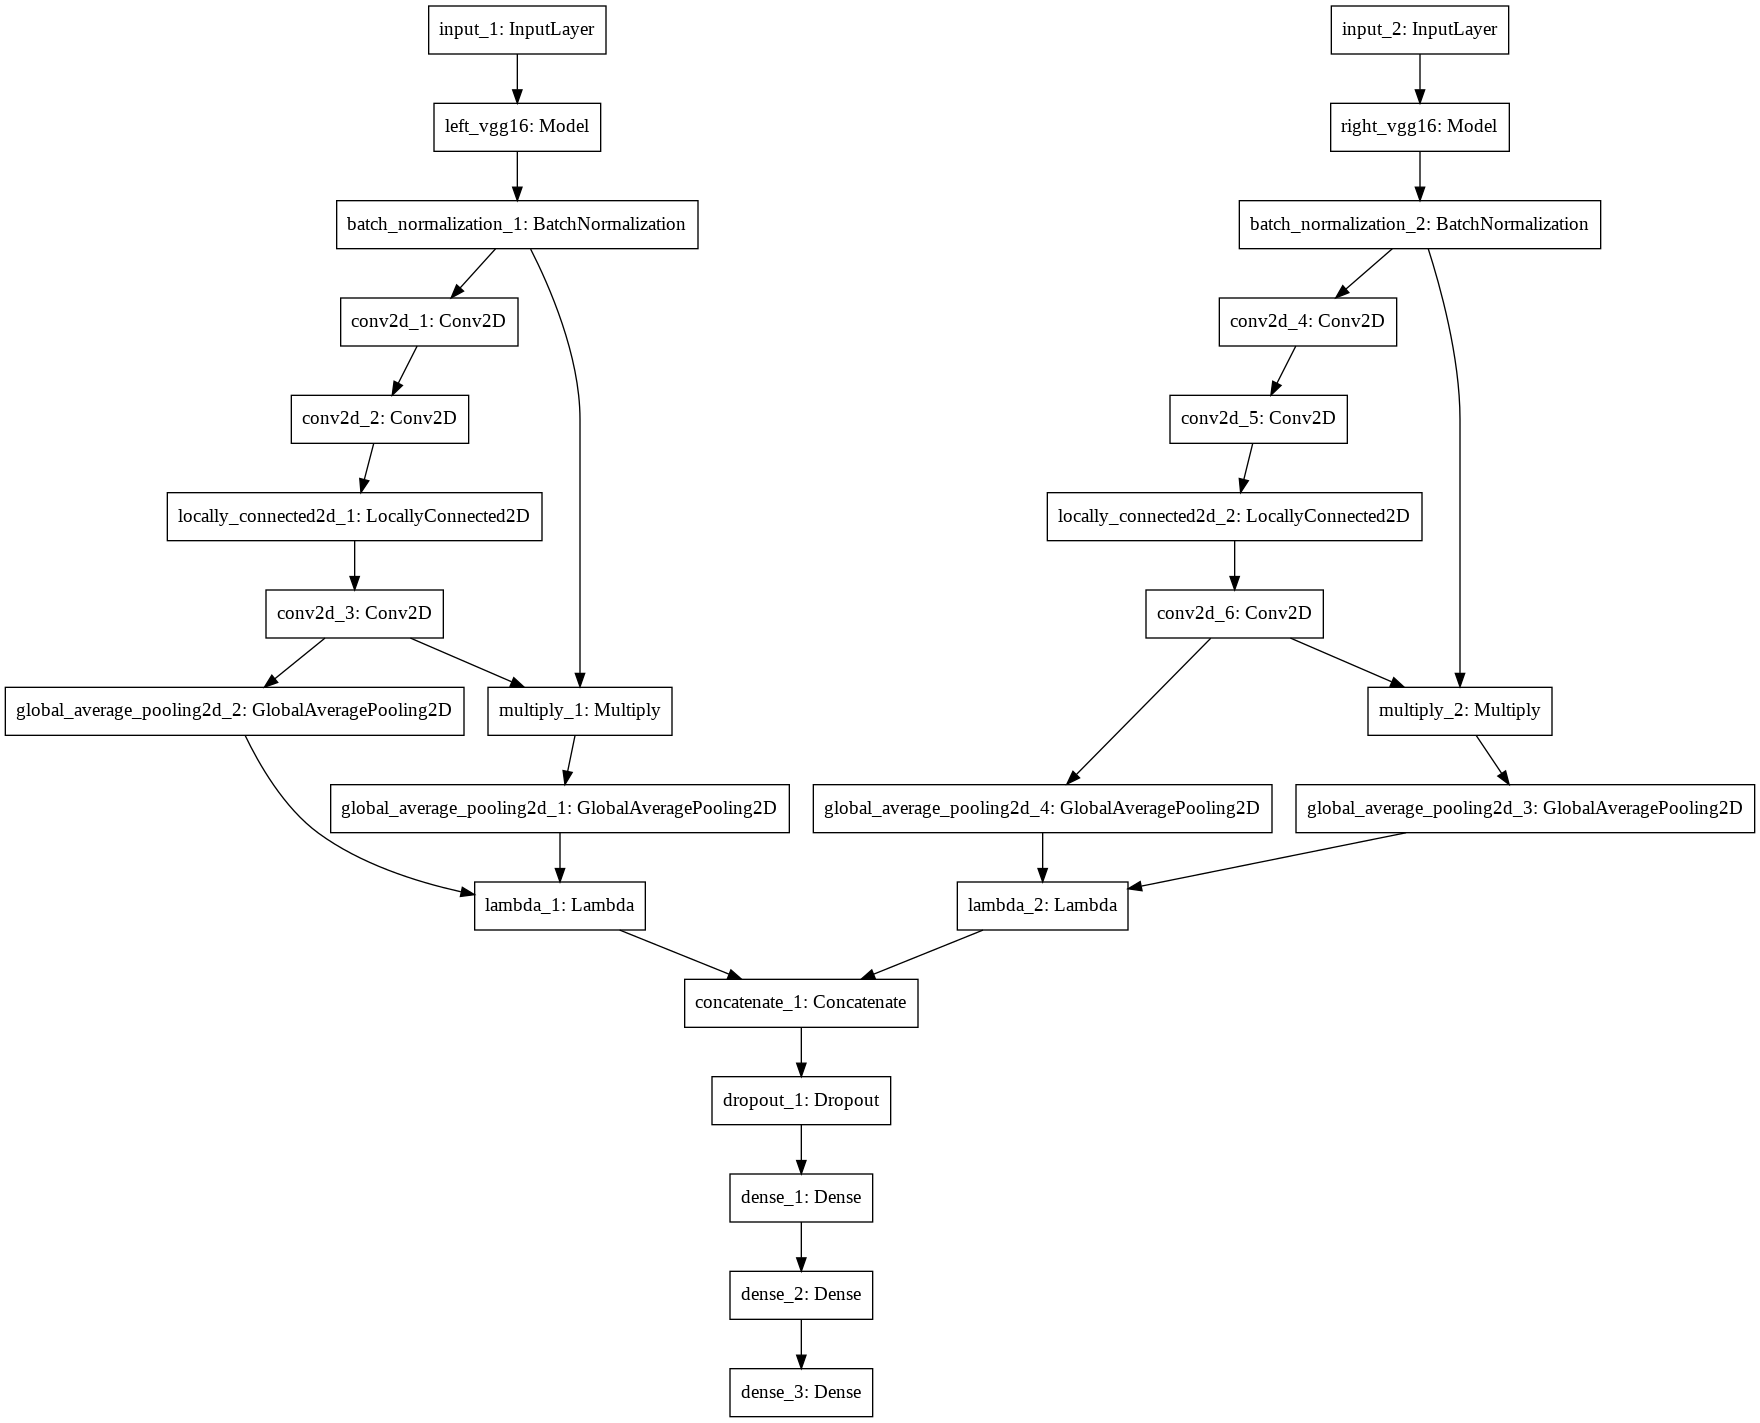

In [33]:
from keras.utils import plot_model
plot_model(model)

In [0]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [0]:
# import keras.backend as K
# def focal_loss(y_true, y_pred, alpha = 0.75, gamma = 3):
#   alpha_factor = K.ones_like(y_true) * alpha
#   alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
#   focal_weight = tf.where(K.equal(y_true, 1), 1 - y_pred, y_pred)
#   focal_weight = alpha_factor * focal_weight ** gamma
#   loss = focal_weight * K.binary_crossentropy(y_true, y_pred)
#   return loss

In [0]:
model.compile('Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
step_size_train=len(annotation)/batch_size
kappa_metrics = Metrics()


In [0]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=2, min_lr=0.000001, verbose=1)

In [0]:
model.fit_generator(train_gen, epochs=10,
                        steps_per_epoch=step_size_train,
                        use_multiprocessing=True,
                        
                        verbose=2,callbacks=[reduce_lr]
                   # class_weight=[0.5,0.5,1.5,1.5,1.5,2.5,1.5,0.5]
                    
                        )

Epoch 1/10
Found 8790 validated image filenames.
Found 8790 validated image filenames.


In [0]:
# y_pred = model.predict_generator(valid_gen,steps=step_size_val)
# y_pred1=y_pred.copy()
# y_pred1[y_pred1>=0.5] = 1
# y_pred1[y_pred1<0.5] = 0
# y_pred1=y_pred1.astype(int)

In [0]:
# y_true=val_annotation.iloc[:,-8::].values
# y_true.shape

In [0]:
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import multilabel_confusion_matrix

# multilabel_confusion_matrix(y_true, y_pred1)

In [0]:
# target_names = ['N'	,'D'	,'G',	'C',	'A'	,'H'	,'M',	'O']
# print(classification_report(y_true, y_pred1, target_names=target_names))

In [0]:
y_test= model.predict_generator(test_gen,steps=len(test)/batch_size)


In [0]:
for i,j in enumerate(['N'	,'D'	,'G',	'C',	'A'	,'H'	,'M',	'O']):
  test[j]=y_test[:,i]

In [0]:
test.head()

In [0]:
test.to_csv('/content/TAC_ODIR.csv',index=False)

In [0]:
keras.backend.clear_session()
